In [1]:
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import numpy as np
def white_noises(sigma, T):
    return np.random.normal(0, sigma, T)

In [23]:
def weighted_noises(parameters):
    noises = []
    for mu in parameters:
        noises.append(np.random.normal(mu, SIGMA, 1)[0])
    return noises

# Learning Model

In [2]:
df = pd.read_csv('stock-table-weekly.csv',header=None)
df.columns = ['ds', 'y']
df = df.iloc[::-1]
df[-10:]
df.plot(x='ds',y='y')
df.tail()

ds          y
4  2016-06-27  37.990002
3  2016-07-05  37.740002
2  2016-07-11  37.720001
1  2016-07-18  39.380001
0  2016-07-25  38.320000

In [5]:
def prophet_simulation(noise, T, boundary=None):
    df_future = df[-500:]
    
    for i in range(T):
        model = Prophet()
        model.fit(df_future[-500:])
        # step by step prediction
        future = model.make_future_dataframe(periods=1)
        next_step = model.predict(future)
        df_future = df_future.append({'ds':next_step['ds'].iloc[-1], 'y':next_step['yhat'].iloc[-1] + noise[i]}, ignore_index=True)
    return df_future

## Fitting Error 

In [9]:
m = Prophet()
m.fit(df[-500:])
f = m.make_future_dataframe(periods=1)
predicted = m.predict(f)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/junyang/anaconda2/envs/p3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
f.tail()

ds
496 2016-07-05
497 2016-07-11
498 2016-07-18
499 2016-07-25
500 2016-07-26

In [12]:
predicted_value = predicted['yhat'].values
true_value = df['y'].tail(500).values

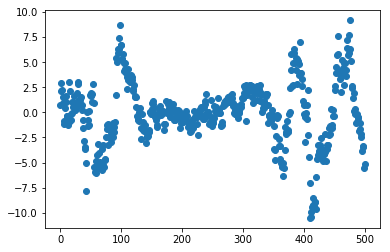

In [22]:
plt.scatter(list(range(500)), predicted_value[:-1] - true_value)

In [31]:
sns.kdeplot(predicted_value[:-1] - true_value)
sns.kdeplot(np.random.normal(0, 2.2, 1000))

In [24]:
print(np.mean(predicted_value[:-1] - true_value), np.var(predicted_value[:-1] - true_value))

-0.0012401437223618715 9.61783262865519


## Simulations

In [32]:
future_dict = {}
for i in range(10):
    noises = white_noises(2.2, 10)
    possible_world = prophet_simulation(noises, 10)
    future_dict[i] = possible_world['y'].values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/junyang/anaconda2/envs/p3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

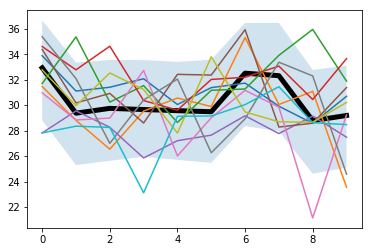

In [36]:
f10 = m.make_future_dataframe(periods=10)
predicted10 = m.predict(f10)
ground_truth = predicted10['yhat'].tail(10).values
upper = predicted10['yhat_upper'].tail(10).values
lower = predicted10['yhat_lower'].tail(10).values
plt.plot(ground_truth, color='black', linewidth='5')
plt.fill_between(range(len(lower)), lower, upper, alpha=0.2)
for key in future_dict:
    plt.plot(future_dict[key][-10:])

# AR Model

In [44]:
sales_data = pd.read_csv('sales_data.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

In [45]:
sales_data.plot()

In [47]:
sales_data['stationary']=sales_data['sales'].diff()
X = sales_data['stationary'].dropna()
X.plot()

In [84]:
from statsmodels.tsa.ar_model import AR
#create train/test datasets
train_data = X[1:len(X)]
#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()

In [85]:
model_fitted.params

const             15055.377307
L1.stationary        -0.943343
L2.stationary        -0.861498
L3.stationary        -0.773592
L4.stationary        -0.721672
L5.stationary        -0.643510
L6.stationary        -0.653977
L7.stationary        -0.679804
L8.stationary        -0.757929
L9.stationary        -0.872484
L10.stationary       -0.972762
L11.stationary       -1.001560
dtype: float64

In [102]:
# fit on training data
predictions = model_fitted.predict(start=20, end=len(train_data), dynamic=False)

In [107]:
value_predictions = [x + sales_data['sales'][idx+19] for idx, x in enumerate(predictions)]

51 51


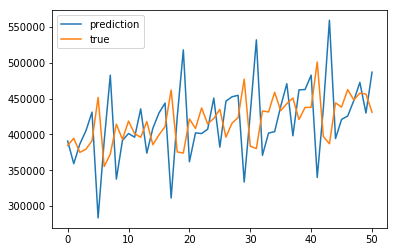

In [110]:
print(len(value_predictions), len(sales_data['sales'][21:]))
plt.plot(value_predictions, label='prediction')
plt.plot(sales_data['sales'][21:].values, label='true')
plt.legend()

In [ ]:
sns.kdeplot(sales_data['sales'][12:].values - np.array(value_predictions))
print(np.mean(sales_data['sales'][12:].values - np.array(value_predictions)))

# Theoretical AR Model

In [79]:
Constant = 5
Phi0 = -0.5
Phi1 = 0.9
def AR_simulation_trace(input_0, input_1, errors, boundary = None):
    sequence = []
    x0 = input_0
    x1 = input_1
    for i in range(len(errors)):
        #print(x0, x1)
        x2 = Constant + Phi0 * x0 + Phi1 * x1 + errors[i]
        sequence.append(x2)
        if boundary is not None and x2 >= boundary:
            break
        x0 = x1
        x1 = x2
    return sequence

def error_sum_test(errors):
    return np.sum(errors)

In [84]:
epsilon = white_noises(2, 50)
plt.plot(AR_simulation_trace(5,5,epsilon))
print(error_sum_test(epsilon))

20.169740532583635


In [44]:
Level = 11
SIGMA = 2

## Simple Random Sampling

In [87]:
def simple_random_sampling(ci_threshold, batch_size, T):
    samples = []
    mean = 0
    ci = 1
    while ci > ci_threshold:
        for i in range(batch_size):
            epsilon = white_noises(SIGMA, T)
            sequence = AR_simulation_trace(5,5,epsilon,Level)
            if len(sequence) >= T:
                samples.append(1)
            else:
                samples.append(0)
        mean = np.mean(samples)
        ci = 1.96 * np.sqrt(np.var(samples) / len(samples))
        #print(mean, ci)
    print(mean, ci)
    print('sample count:{}'.format(len(samples)))

def simple_random_sampling_test(ci_threshold, batch_size, T, sum_threshold):
    samples = []
    mean = 0
    ci = 1000
    while ci > ci_threshold:
        for i in range(batch_size):
            epsilon = white_noises(SIGMA, T)
            error_sum = error_sum_test(epsilon)
            if error_sum >= sum_threshold:
                samples.append(1)
            else:
                samples.append(0)
        mean = np.mean(samples)
        ci = 1.96 * np.sqrt(np.var(samples) / len(samples))
        #print(mean, ci)
    print(mean, ci)
    print('sample count:{}'.format(len(samples)))

In [111]:
simple_random_sampling(0.01, 1000000, 50)

0.000891 5.847919139959445e-05
sample count:1000000


In [106]:
simple_random_sampling_test(0.01, 1000, 50, 20)

0.07766666666666666 0.009577600754228973
sample count:3000


## Importance Sampling (Cross-Entropy)

In [107]:
def relative_likelihood(epsilon, parameters):
    return np.exp((1 / (2 * SIGMA**2)) * \
                  np.sum([(epsilon[i] - parameters[i])**2 - epsilon[i]**2 for i in range(len(epsilon))]))

def cross_entropy_update(rho, opt_parameters, T):
    # step 1 : generate samples
    samples = []
    generated_samples = []
    for i in range(1000):
        epsilon = weighted_noises(opt_parameters)
        generated_samples.append(epsilon)
        sequence = AR_simulation_trace(5,5,epsilon, Level)
        if len(sequence) < T:
            samples.append(len(sequence))
        else:
            samples.append(T)
    # step 2 : find (1 - rho) quantile
    sorted_samples = sorted(samples)
    position = int((1 - rho) * (len(sorted_samples) + 1))
    level_hat = sorted_samples[position]
    #print(sorted_samples, position, level_hat)
    
    # step 3 : update sampling distribution
    new_parameters = opt_parameters
    for j in range(T):
        relative_weight = relative_likelihood(generated_samples[i], opt_parameters)
        up = np.sum([relative_weight * generated_samples[i][j] \
              for i in range(len(samples)) if samples[i] >= level_hat])
        down = np.sum([relative_weight for i in range(len(samples)) if samples[i] >= level_hat])
        new_parameters[j] = up / down
    
    #print(new_parameters, level_hat)
    stop = 0
    if level_hat >= T:
        stop = 1
    return new_parameters, stop

def cross_entropy_update_test(rho, opt_parameters, T, sum_threshold):
    # step 1 : generate samples
    samples = []
    generated_samples = []
    for i in range(1000):
        epsilon = weighted_noises(opt_parameters)
        generated_samples.append(epsilon)
#         sequence = AR_simulation_trace(5,5,epsilon, Level)
#         if len(sequence) < T:
#             samples.append(len(sequence))
#         else:
#             samples.append(T)
        samples.append(error_sum_test(epsilon))
    # step 2 : find (1 - rho) quantile
    sorted_samples = sorted(samples)
    position = int((1 - rho) * (len(sorted_samples) + 1))
    level_hat = sorted_samples[position]
    #print(sorted_samples, position, level_hat)
    
    # step 3 : update sampling distribution
    new_parameters = opt_parameters
    for j in range(T):
        relative_weight = relative_likelihood(generated_samples[i], opt_parameters)
        up = np.sum([relative_weight * generated_samples[i][j] \
              for i in range(len(samples)) if samples[i] >= level_hat])
        down = np.sum([relative_weight for i in range(len(samples)) if samples[i] >= level_hat])
        new_parameters[j] = up / down
    
    #print(new_parameters, level_hat)
    stop = 0
    if level_hat >= sum_threshold:
        stop = 1
    return new_parameters, stop

In [108]:
def importance_sampling(ci_threshold, batch_size, params, T):
    samples = []
    generated_errors = []
    mean = 0
    ci = 1
    while ci > ci_threshold:
        for i in range(batch_size):
            epsilon = weighted_noises(params)
            generated_errors.append(epsilon)
            sequence = AR_simulation_trace(5,5,epsilon, Level)
            if len(sequence) >= T:
                samples.append(1)
            else:
                samples.append(0)
        weighted_samples = [samples[idx] * relative_likelihood(generated_errors[idx], params) \
                       for idx in range(len(samples))]
        mean = np.mean(weighted_samples)
        ci = 1.96 * np.sqrt(np.var(weighted_samples) / len(samples))
        print(mean, ci)
    print('sample count : {}'.format(len(samples)))

def importance_sampling_test(ci_threshold, batch_size, params, T, sum_threshold):
    samples = []
    generated_errors = []
    mean = 0
    ci = 1
    while ci > ci_threshold:
        for i in range(batch_size):
            epsilon = weighted_noises(params)
            generated_errors.append(epsilon)
#             sequence = AR_simulation_trace(5,5,epsilon, Level)
#             if len(sequence) >= T:
#                 samples.append(1)
#             else:
#                 samples.append(0)
            error_sum = error_sum_test(epsilon)
            if error_sum >= sum_threshold:
                samples.append(1)
            else:
                samples.append(0)
        weighted_samples = [samples[idx] * relative_likelihood(generated_errors[idx], params) \
                       for idx in range(len(samples))]
        mean = np.mean(weighted_samples)
        ci = 1.96 * np.sqrt(np.var(weighted_samples) / len(samples))
        print(mean, ci)
    print('sample count : {}'.format(len(samples)))

In [109]:
sample_count = 0
dist_params = [0] * 50
while True:
    dist_params, flag = cross_entropy_update(0.1, dist_params, 50)
    if flag == 1:
        break
    sample_count += 100
print(sample_count)
print(dist_params)

700
[-0.9626372593478828, -2.3333495097583516, -2.0071548125535457, -2.0498538328103355, -1.944332396565812, -2.1288180368243217, -2.442572663698321, -1.7991289098562249, -2.2462372039731875, -1.9320779543904256, -2.2480033687524035, -1.3722365951588447, -1.7353306451966821, -2.154299897875929, -2.151019372981561, -2.1595025623622557, -1.8928087218435319, -1.7199871649059058, -1.6114562316582515, -1.6419291811365828, -2.1602528867736654, -1.8347235870591234, -1.5319475308395025, -2.004997787733033, -1.9506352131519349, -1.361880441815626, -2.1897929327615153, -1.0350371974219061, -1.9842555646895035, -1.5491374052176745, -1.8645175557678833, -1.5020279862799277, -1.221363846779324, -1.9468702615489533, -1.365846799590407, -1.5902702685502779, -1.0642932376136847, -1.0049196840000643, -2.014150876457837, -0.29331512808994276, -2.220915731241059, -0.17008251729314242, -1.0930734399474076, -1.8639384164362487, -0.6059543681623037, -0.3301272716286737, -1.484211899377126, -0.48365510804450

In [97]:
sample_count = 0
dist_params = [0] * 50
while True:
    dist_params, flag = cross_entropy_update_test(0.1, dist_params, 50, 20)
    if flag == 1:
        break
    sample_count += 100
print(sample_count)
print(dist_params)

100
[1.2822019266899096, 1.3171280963874699, 1.3046261049359804, 1.283225385226858, 1.0202431831852299, 1.212388241802371, 1.2760325967985777, 0.5887296492083642, 0.7064010189007432, 0.5146986542386903, 1.0607300933367907, 0.9046034327666046, 0.9632977301020581, 0.6620472689226421, 0.9241125435458488, 0.9929308447125436, 1.3993243029148474, 1.0499528401697529, 0.9330376798074725, 0.8475585879620028, 1.163204617547237, 0.6897683142479913, 0.3437926871429871, 1.4464742011482004, 1.371603206946346, 1.08738864418382, 1.2844965517406977, 1.1437442122777597, 0.7761223339937091, 1.4045189496806556, 0.854409283330756, 1.1459129382720266, 1.0782936341264022, 0.7846801075755482, 0.8695077401711965, 1.2612191660310086, 0.22654569849759448, 0.5365702843176572, 0.7043043300954795, 0.9212449357654852, 0.5186502459942534, 1.2314873585166086, 0.42344546299602126, 0.7905402871854559, 0.6364943190283596, 0.9584064792967895, 1.443371509068788, 0.5486310944417131, 1.2423027477876014, 1.459161069704035]


In [110]:
importance_sampling(0.01, 2000, dist_params ,50)

1.4418020163786832e-05 2.1798046611761296e-05
sample count : 2000


In [103]:
importance_sampling_test(0.01, 1000, dist_params, 50, 20)

0.11187299935220796 0.014026911115988916
0.11333215926744115 0.010136362747622779
0.113582690103671 0.008049846182776127
sample count : 3000


# curves

In [239]:
google_stock = pd.read_csv('google_stock.csv')
price_delta = google_stock['Close'].diff()
#price_delta.head()
#google_stock['Close'].tail()

In [247]:
increase_ratio = []
for i in range(1, len(price_delta)):
    increase_ratio.append(price_delta[i] / google_stock['Close'][i-1])

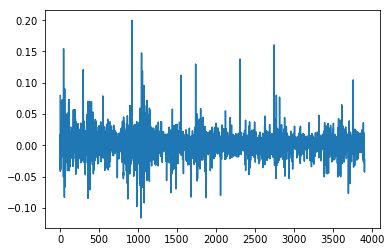

In [248]:
plt.plot(increase_ratio)

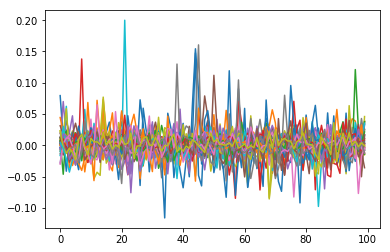

In [249]:
for i in range(0, len(increase_ratio), 100):
    plt.plot(increase_ratio[i:i+100])